# OpenVINO™를 이용한 YOLOv11 실시간 객체 감지 변환 및 최적화

실시간 객체 감지는 컴퓨터 비전 시스템의 핵심 구성 요소로 자주 사용됩니다.
실시간 객체 감지 모델을 사용하는 애플리케이션에는 비디오 분석, 로봇 공학, 자율주행차, 다중 객체 추적 및 객체 계수, 의료 영상 분석 등이 있습니다.

이 튜토리얼에서는 OpenVINO를 사용하여 PyTorch YOLOv11을 실행하고 최적화하는 방법을 단계별로 설명합니다. 객체 감지 시나리오에 필요한 단계를 고려합니다. 모델에 대한 자세한 내용은 Ultralytics 설명서의 [모델 페이지](https://docs.ultralytics.com/models/yolo11/)에서 확인할 수 있습니다.

이 튜토리얼은 다음 단계로 구성됩니다.
- PyTorch 모델 준비
- 데이터세트 다운로드 및 준비
- 원본 모델 검증
- PyTorch 모델을 OpenVINO IR로 변환
- 최적화 파이프라인 준비 및 실행
- FP32 모델과 양자화된 모델의 성능 비교
- OpenVINO API를 활용한 기타 최적화 가능성
- 라이브 데모

#### 목차:

- [PyTorch 모델 가져오기](#Get-PyTorch-model)
- [필수 조건](#Prerequisites)
- [모델 인스턴스화](#Instantiate-model)
- [모델을 OpenVINO IR로 변환](#Convert-model-to-OpenVINO-IR)
- [모델 추론 검증](#Verify-model-inference)
- [추론 장치 선택](#Select-inference-device)
- [단일 이미지 테스트](#Test-on-single-image)
- [NNCF 학습 후 양자화 API를 사용하여 모델 최적화](#Optimize-model-using-NNCF-Post-training-Quantization-API)
- [양자화된 모델 추론 검증](#Validate-Quantized-model-inference)
- [원본 비교 및 양자화된 모델](#Compare-the-Original-and-Quantized-Models)
- [성능 객체 감지 모델 비교](#Compare-performance-object-detection-models)
- [다음 단계](#Next-steps)
- [비동기 추론 파이프라인](#Async-inference-pipeline)
- [실시간 데모](#Live-demo)
- [실시간 객체 감지 실행](#Run-Live-Object-Detection)





## PyTorch 모델 가져오기
[맨 위로 ⬆️](#목차:)

일반적으로 PyTorch 모델은 [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) 클래스의 인스턴스를 나타내며, 모델 가중치가 포함된 상태 사전으로 초기화됩니다.
이 [repo](https://github.com/ultralytics/ultralytics)에서 제공되는 COCO 데이터셋으로 사전 학습된 YOLOv11 나노 모델(`yolo11n`이라고도 함)을 사용합니다. 다른 YOLOv11 모델에도 유사한 단계를 적용할 수 있습니다.
사전 학습된 모델을 얻는 일반적인 단계는 다음과 같습니다.
1. 모델 클래스의 인스턴스를 생성합니다.
2. 사전 학습된 모델 가중치가 포함된 체크포인트 상태 사전을 로드합니다.
3. 일부 연산을 추론 모드로 전환하기 위해 모델을 평가 모드로 전환합니다.

이 경우, 모델 생성자는 YOLOv11 모델을 OpenVINO IR로 변환할 수 있는 API를 제공합니다. 따라서 이러한 단계를 수동으로 수행할 필요가 없습니다.

#### 필수 구성 요소
[맨 위로 ⬆️](#목차:)

필요한 패키지를 설치하세요.

In [1]:
import platform


%pip install -q "openvino>=2025.1.0" "nncf>=2.16.0"
%pip install -q "torch>=2.1" "torchvision>=0.16" "ultralytics==8.3.142" onnx tqdm opencv-python --extra-index-url https://download.pytorch.org/whl/cpu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/

필요한 유틸리티 함수를 가져옵니다.

아래쪽 셀은 GitHub에서 `notebook_utils` Python 모듈을 다운로드합니다.

In [2]:
from pathlib import Path
import requests


if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )

    open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, VideoPlayer, device_widget, quantization_widget

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("yolov11-object-detection.ipynb")

In [3]:
# Download a test sample
IMAGE_PATH = Path("./data/coco_bike.jpg")

if not IMAGE_PATH.exists():
    download_file(
        url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg",
        filename=IMAGE_PATH.name,
        directory=IMAGE_PATH.parent,
    )

coco_bike.jpg:   0%|          | 0.00/182k [00:00<?, ?B/s]

## 모델 인스턴스화
[맨 위로 ⬆️](#목차:)

원래 저장소에는 다양한 작업을 위해 [여러 모델](https://docs.ultralytics.com/tasks/detect/)이 있습니다. 모델을 로드하려면 모델 체크포인트 경로를 지정해야 합니다. 모델 허브에서 사용 가능한 로컬 경로 또는 이름을 사용할 수 있습니다(이 경우 모델 체크포인트가 자동으로 다운로드됩니다).

아래 위젯을 사용하여 표시된 모델 중 하나를 선택할 수 있습니다.

In [4]:
import ipywidgets as widgets

model_id = ["yolo11n", "yolo11s", "yolo11m", "yolo11l", "yolo11x", "yolov8n", "yolov8s", "yolov8m", "yolov8l", "yolov8x"]

model_name = widgets.Dropdown(options=model_id, value=model_id[0], description="Model")

model_name

Dropdown(description='Model', options=('yolo11n', 'yolo11s', 'yolo11m', 'yolo11l', 'yolo11x', 'yolov8n', 'yolo…

예측을 수행하는 모델은 입력 이미지 경로를 입력받아 Results 클래스 객체를 포함하는 목록을 반환합니다. Results는 객체 감지 모델을 위한 상자를 포함합니다. 또한 결과를 처리하는 유틸리티(예: 그리기를 위한 `plot()` 메서드)도 포함합니다.

다음과 같은 예를 살펴보겠습니다.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 18.0MB/s]



image 1/1 /content/data/coco_bike.jpg: 480x640 2 bicycles, 2 cars, 2 dogs, 429.6ms
Speed: 17.7ms preprocess, 429.6ms inference, 35.1ms postprocess per image at shape (1, 3, 480, 640)


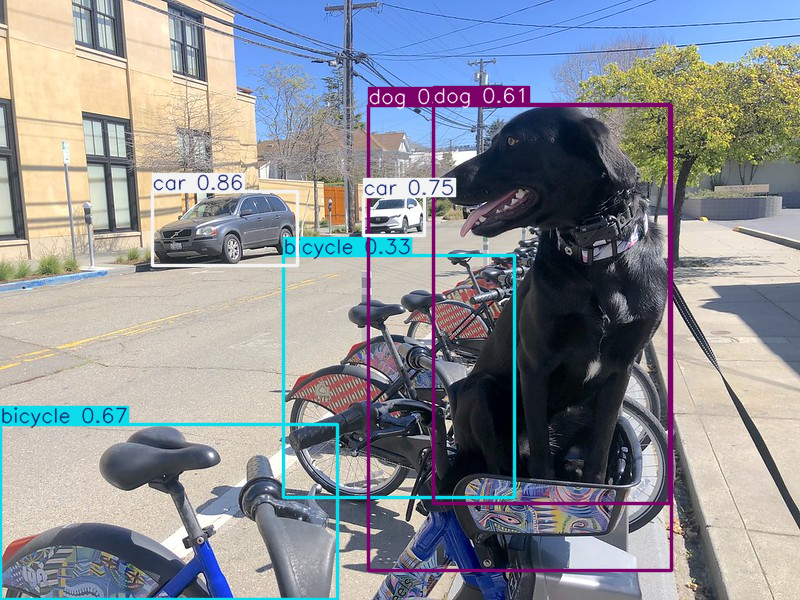

In [5]:
from PIL import Image
from ultralytics import YOLO

DET_MODEL_NAME = model_name.value

det_model = YOLO(f"{DET_MODEL_NAME}.pt")
det_model.to("cpu")
label_map = det_model.model.names

res = det_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

### 모델을 OpenVINO IR로 변환
[맨 위로 ⬆️](#목차:)

Ultralytics는 OpenVINO IR을 포함한 다양한 형식으로 모델을 편리하게 내보낼 수 있는 API를 제공합니다. `model.export`는 모델 변환을 담당합니다. 형식을 지정해야 하며, 모델의 동적 형태를 유지할 수도 있습니다.

In [6]:
# object detection model
det_model_path = Path(f"{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml")
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=True)

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.4 MB)

OpenVINO: starting export with openvino 2025.1.0-18503-6fec06580ab-releases/2025/1...
OpenVINO: export success ✅ 7.2s, saved as 'yolo11n_openvino_model/' (5.4 MB)

Export complete (7.7s)
Results saved to /content
Predict:         yolo predict task=detect model=yolo11n_openvino_model imgsz=640 half 
Validate:        yolo val task=detect model=yolo11n_openvino_model imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml half 
Visualize:       https://netron.app


### 모델 추론 검증
[맨 위로 ⬆️](#목차:)

OpenVINO로 추론을 실행할 때 Intel 장치(intel:gpu, intel:npu, intel:cpu)를 지정하여 기본 모델 파이프라인을 재사용할 수 있습니다.

### 추론 장치 선택
[맨 위로 ⬆️](#목차:)

OpenVINO를 사용하여 추론을 실행하려면 드롭다운 목록에서 장치를 선택하세요.

In [7]:
device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### 단일 이미지 테스트
[맨 위로 ⬆️](#목차:)

이제 전처리 및 후처리 단계를 정의했으므로 객체 감지를 위한 모델 예측을 확인할 준비가 되었습니다.

Loading yolo11n_openvino_model for OpenVINO inference...
WARNING ⚠️ OpenVINO device 'AUTO' not available. Using 'AUTO' instead.
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 /content/data/coco_bike.jpg: 480x640 2 bicycles, 2 cars, 2 dogs, 237.6ms
Speed: 4.4ms preprocess, 237.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


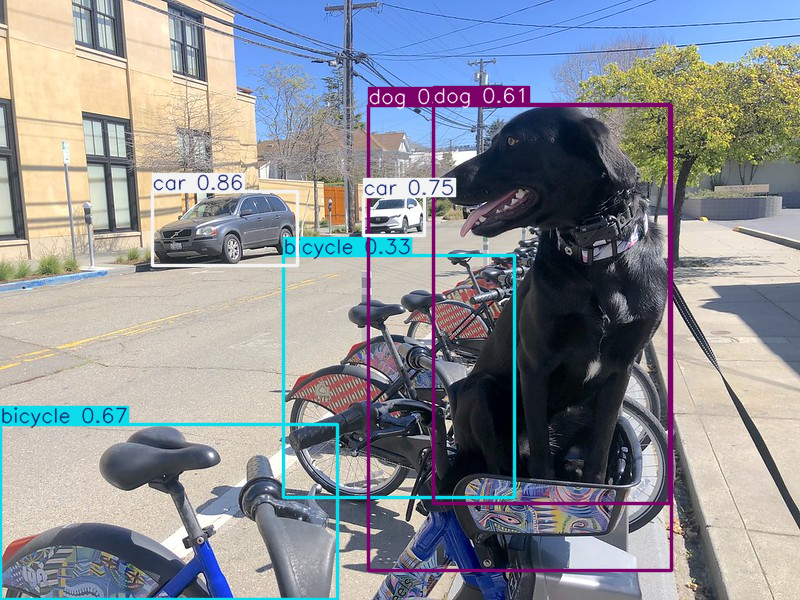

In [8]:
det_model = YOLO(det_model_path.parent, task="detect")

res = det_model(IMAGE_PATH, device=f"intel:{device.value.lower()}")
Image.fromarray(res[0].plot()[:, :, ::-1])

## NNCF 학습 후 양자화 API를 사용하여 모델 최적화
[맨 위로 ⬆️](#목차:)

[NNCF](https://github.com/openvinotoolkit/nncf)는 OpenVINO에서 정확도 저하를 최소화하면서 신경망 추론 최적화를 위한 고급 알고리즘 모음을 제공합니다.
모델 최적화를 위해 학습 후 모드에서 8비트 양자화를 사용합니다(미세 조정 파이프라인 없음).

최적화 프로세스는 다음 단계로 구성됩니다.

1. 양자화를 위한 데이터셋을 생성합니다.
2. 최적화된 모델을 얻기 위해 `nncf.quantize`를 실행합니다.
3. `openvino.save_model` 함수를 사용하여 OpenVINO IR 모델을 직렬화합니다.

모델 추론 속도를 개선하기 위해 양자화를 실행할지 여부를 아래에서 선택하세요.

In [9]:
int8_model_det_path = Path(f"{DET_MODEL_NAME}_openvino_model_int8/{DET_MODEL_NAME}.xml")
quantized_det_model = None

to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

`to_quantize`가 선택되지 않은 경우 양자화를 건너뛰려면 `skip magic` 확장을 로드해 보겠습니다.

In [10]:
if not Path("skip_kernel_extension.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
    )
    open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

In [11]:
%%skip not $to_quantize.value

from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.converter import coco80_to_coco91_class
from ultralytics.data.utils import check_det_dataset
from zipfile import ZipFile

from ultralytics.data.utils import DATASETS_DIR


DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"
CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/v8.1.0/ultralytics/cfg/datasets/coco.yaml"

OUT_DIR = DATASETS_DIR

DATA_PATH = OUT_DIR / "val2017.zip"
LABELS_PATH = OUT_DIR / "coco2017labels-segments.zip"
CFG_PATH = OUT_DIR / "coco.yaml"

if not int8_model_det_path.exists():
    if not (OUT_DIR / "coco/labels").exists():
        download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
        download_file(LABELS_URL, LABELS_PATH.name, LABELS_PATH.parent)
        download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)
        with ZipFile(LABELS_PATH, "r") as zip_ref:
            zip_ref.extractall(OUT_DIR)
        with ZipFile(DATA_PATH, "r") as zip_ref:
            zip_ref.extractall(OUT_DIR / "coco/images")


    args = get_cfg(cfg=DEFAULT_CFG)
    args.data = str(CFG_PATH)
    det_validator = det_model.task_map[det_model.task]["validator"](args=args)
    det_validator.data = check_det_dataset(args.data)
    det_validator.stride = 32
    det_data_loader = det_validator.get_dataloader(OUT_DIR / "coco", 1)

    det_validator.is_coco = True
    det_validator.class_map = coco80_to_coco91_class()
    det_validator.names = label_map
    det_validator.metrics.names = det_validator.names
    det_validator.nc = 80

val2017.zip:   0%|          | 0.00/778M [00:00<?, ?B/s]

coco2017labels-segments.zip:   0%|          | 0.00/169M [00:00<?, ?B/s]

coco.yaml:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

100%|██████████| 755k/755k [00:00<00:00, 3.73MB/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1316.4±582.2 MB/s, size: 179.0 KB)


val: Scanning /content/datasets/coco/labels/val2017... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:08<00:00, 576.43it/s]


val: New cache created: /content/datasets/coco/labels/val2017.cache


양자화 정확도 테스트에서 검증 데이터로더를 재사용합니다.
이를 위해서는 `nncf.Dataset` 객체로 래핑하고 입력 텐서만 가져오는 변환 함수를 정의해야 합니다.

In [12]:
%%skip not $to_quantize.value

import nncf


if not int8_model_det_path.exists():


    def transform_fn(data_item:dict):
        """
        Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
        Parameters:
        data_item: Dict with data item produced by DataLoader during iteration
        Returns:
            input_tensor: Input data for quantization
        """
        input_tensor = det_validator.preprocess(data_item)['img'].numpy()
        return input_tensor


    quantization_dataset = nncf.Dataset(det_data_loader, transform_fn)

`nncf.quantize` 함수는 모델 양자화를 위한 인터페이스를 제공합니다. OpenVINO 모델 및 양자화 데이터세트의 인스턴스가 필요합니다.
선택적으로, 구성 양자화 프로세스에 대한 몇 가지 추가 매개변수(양자화 샘플 수, 사전 설정, 무시된 범위 등)를 제공할 수 있습니다. Ultralytics 모드에는 ReLU가 아닌 활성화 함수가 포함되어 있으며, 이는 활성화 함수의 비대칭 양자화를 요구합니다. 더 나은 결과를 얻기 위해 `mixed` 양자화 사전 설정을 사용합니다. 이 사전 설정은 가중치의 대칭 양자화와 활성화 함수의 비대칭 양자화를 제공합니다. 더 정확한 결과를 얻으려면 `ignored_scope` 매개변수를 사용하여 후처리 서브그래프에서 부동 소수점 정밀도로 연산을 유지해야 합니다.

>**참고**: 모델 학습 후 양자화는 시간이 많이 소요되는 프로세스입니다. 하드웨어에 따라 몇 분 정도 걸릴 수 있으니 양해 부탁드립니다.

In [13]:
%%skip not $to_quantize.value

import shutil
import openvino as ov

core = ov.Core()

det_ov_model = core.read_model(det_model_path)


if not int8_model_det_path.exists():
    ignored_scope = nncf.IgnoredScope( # post-processing
        subgraphs=[
            nncf.Subgraph(inputs=[f"__module.model.{22 if 'v8' in DET_MODEL_NAME else 23}/aten::cat/Concat",
                                f"__module.model.{22 if 'v8' in DET_MODEL_NAME else 23}/aten::cat/Concat_1",
                                f"__module.model.{22 if 'v8' in DET_MODEL_NAME else 23}/aten::cat/Concat_2"],
                        outputs=[f"__module.model.{22 if 'v8' in DET_MODEL_NAME else 23}/aten::cat/Concat_7"])
        ]
    )

    # Detection model
    quantized_det_model = nncf.quantize(
        det_ov_model,
        quantization_dataset,
        preset=nncf.QuantizationPreset.MIXED,
        ignored_scope=ignored_scope
    )
    print(f"Quantized detection model will be saved to {int8_model_det_path}")
    ov.save_model(quantized_det_model, str(int8_model_det_path))
    shutil.copy(det_model_path.parent / "metadata.yaml", int8_model_det_path.parent / "metadata.yaml")

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.11/dist-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(


INFO:nncf:108 ignored nodes were found by subgraphs in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 132 __module.model.23/aten::cat/Concat
INFO:nncf:Not adding activation input quantizer for operation: 140 __module.model.23/aten::view/Reshape_3
INFO:nncf:Not adding activation input quantizer for operation: 277 __module.model.23/aten::cat/Concat_1
INFO:nncf:Not adding activation input quantizer for operation: 287 __module.model.23/aten::view/Reshape_4
INFO:nncf:Not adding activation input quantizer for operation: 385 __module.model.23/aten::cat/Concat_2
INFO:nncf:Not adding activation input quantizer for operation: 388 __module.model.23/aten::view/Reshape_5
INFO:nncf:Not adding activation input quantizer for operation: 151 __module.model.23/aten::cat/Concat_4
INFO:nncf:Not adding activation input quantizer for operation: 164 __module.model.23/prim::ListUnpack
INFO:nncf:Not adding activation input quantizer for operation: 181 __module.model.23.dfl/aten::vi

Output()

Output()

Quantized detection model will be saved to yolo11n_openvino_model_int8/yolo11n.xml


### 양자화된 모델 추론 검증
[맨 위로 ⬆️](#목차:)

`nncf.quantize`는 OpenVINO 모델 클래스 인스턴스를 반환하며, 이는 예측을 위해 장치에 로딩하는 데 적합합니다. `INT8` 모델 입력 데이터와 출력 결과 형식은 부동 소수점 모델 표현과 차이가 없습니다. 따라서 위에 정의된 동일한 `detect` 함수를 재사용하여 이미지에서 `INT8` 모델 결과를 얻을 수 있습니다.

In [14]:
%%skip not $to_quantize.value

display(device)

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

Loading yolo11n_openvino_model_int8 for OpenVINO inference...
WARNING ⚠️ OpenVINO device 'AUTO' not available. Using 'AUTO' instead.
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 /content/data/coco_bike.jpg: 480x640 2 bicycles, 2 cars, 2 dogs, 231.9ms
Speed: 16.6ms preprocess, 231.9ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 640)


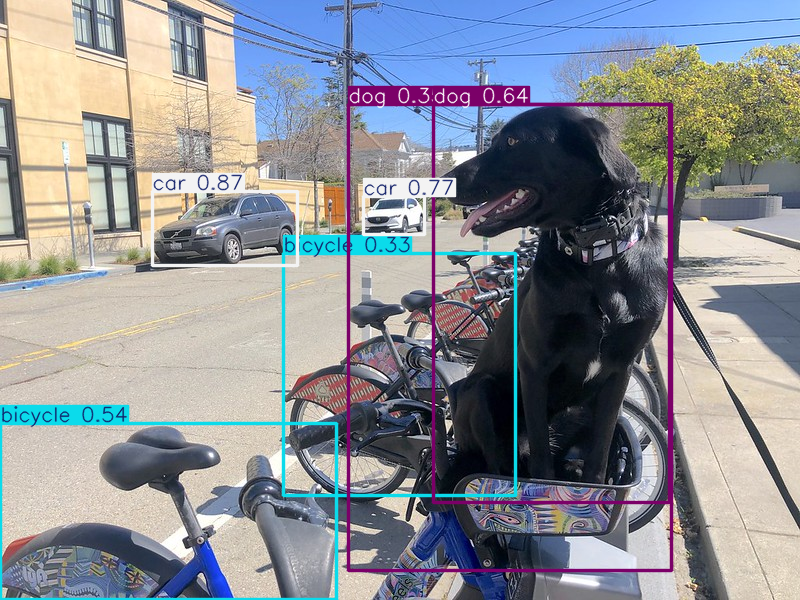

In [15]:
%%skip not $to_quantize.value

det_model = YOLO(int8_model_det_path.parent, task="detect")

res = det_model(IMAGE_PATH, device=f"intel:{device.value.lower()}")
display(Image.fromarray(res[0].plot()[:, :, ::-1]))

## 원본 모델과 양자화된 모델 비교
[맨 위로 ⬆️](#목차:)

### 성능 객체 감지 모델 비교
[맨 위로 ⬆️](#목차:)

마지막으로, OpenVINO [벤치마크 도구](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html)를 사용하여 `FP32` 및 `INT8` 모델의 추론 성능을 측정합니다.

> **참고**: 더 정확한 성능을 얻으려면 다른 애플리케이션을 닫은 후 터미널/명령 프롬프트에서 `benchmark_app`을 실행하는 것이 좋습니다. `benchmark_app -m <model_path> -d CPU -shape "<input_shape>"`를 실행하여 특정 입력 데이터 형태에 대해 1분 동안 CPU에서 비동기 추론을 벤치마크합니다. GPU에서 벤치마크하려면 `CPU`를 `GPU`로 변경합니다. 모든 명령줄 옵션에 대한 개요를 보려면 `benchmark_app --help`를 실행합니다.

In [16]:
%%skip not $to_quantize.value

display(device)

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [17]:
if int8_model_det_path.exists():
    # Inference FP32 model (OpenVINO IR)
    !benchmark_app -m $det_model_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 34.47 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.23/aten::cat/Concat_7) : f32 / [...] / [?,84,21..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch si

In [18]:
if int8_model_det_path.exists():
    # Inference INT8 model (OpenVINO IR)
    !benchmark_app -m $int8_model_det_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 52.44 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.23/aten::cat/Concat_7) : f32 / [...] / [?,84,21..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch si

## 다음 단계

[맨 위로 ⬆️](#목차:)

이 섹션에서는 OpenVINO를 사용하여 애플리케이션 성능을 추가로 개선하는 방법에 대한 제안을 제공합니다.

### 비동기 추론 파이프라인

[맨 위로 ⬆️](#목차:)

비동기 API의 주요 장점은 기기가 추론 작업을 수행 중일 때 애플리케이션이 현재 추론이 먼저 완료될 때까지 기다리지 않고 다른 작업(예: 입력 채우기 또는 다른 요청 스케줄링)을 병렬로 수행할 수 있다는 것입니다. openvino를 사용하여 비동기 추론을 수행하는 방법을 알아보려면 [비동기 API 튜토리얼](../async-api/async-api.ipynb)을 참조하세요.

## 라이브 데모
[맨 위로 ⬆️](#목차:)

다음 코드는 비디오에서 모델 추론을 실행합니다.

In [19]:
import collections
import time
from IPython import display
import cv2
import numpy as np


# Main processing function to run object detection.
def run_object_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=det_model,
    device=device.value,
    video_width: int = None,  # if not set the original size is used
):
    player = None

    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break

            if video_width:
                # If the frame is larger than video_width, reduce size to improve the performance.
                # If more, increase size for better demo expirience.

                scale = video_width / max(frame.shape)
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Get the results.
            input_image = np.array(frame)

            start_time = time.time()
            detections = det_model(input_image, verbose=False, device=f"intel:{device.lower()}")
            stop_time = time.time()
            frame = detections[0].plot()

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### 실시간 객체 감지 실행
[맨 위로 ⬆️](#목차:)

웹캠을 비디오 입력으로 사용하세요. 기본적으로 기본 웹캠은 `source=0`으로 설정되어 있습니다. 웹캠이 여러 개인 경우 각 웹캠에 0부터 시작하는 연속 번호가 지정됩니다. 전면 카메라를 사용하는 경우 `flip=True`를 설정하세요. 일부 웹 브라우저, 특히 Mozilla Firefox는 깜박임을 유발할 수 있습니다. 깜박임이 발생하면 `use_popup=True`를 설정하세요.

>**참고**: 이 노트북을 웹캠과 함께 사용하려면 웹캠이 있는 컴퓨터에서 실행해야 합니다. 원격 서버(예: Binder 또는 Google Colab 서비스)에서 노트북을 실행하면 웹캠이 작동하지 않습니다. 기본적으로 아래쪽 셀은 비디오 파일에 대해 모델 추론을 실행합니다. 웹캠에서 실시간 추론을 사용하려면 `WEBCAM_INFERENCE = True`를 설정하세요.

객체 감지 실행:

In [20]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    VIDEO_SOURCE = "people.mp4"
    if not Path(VIDEO_SOURCE).exists():
        download_file(
            "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4",
            "people.mp4",
        )

people.mp4:   0%|          | 0.00/3.54M [00:00<?, ?B/s]

In [21]:
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

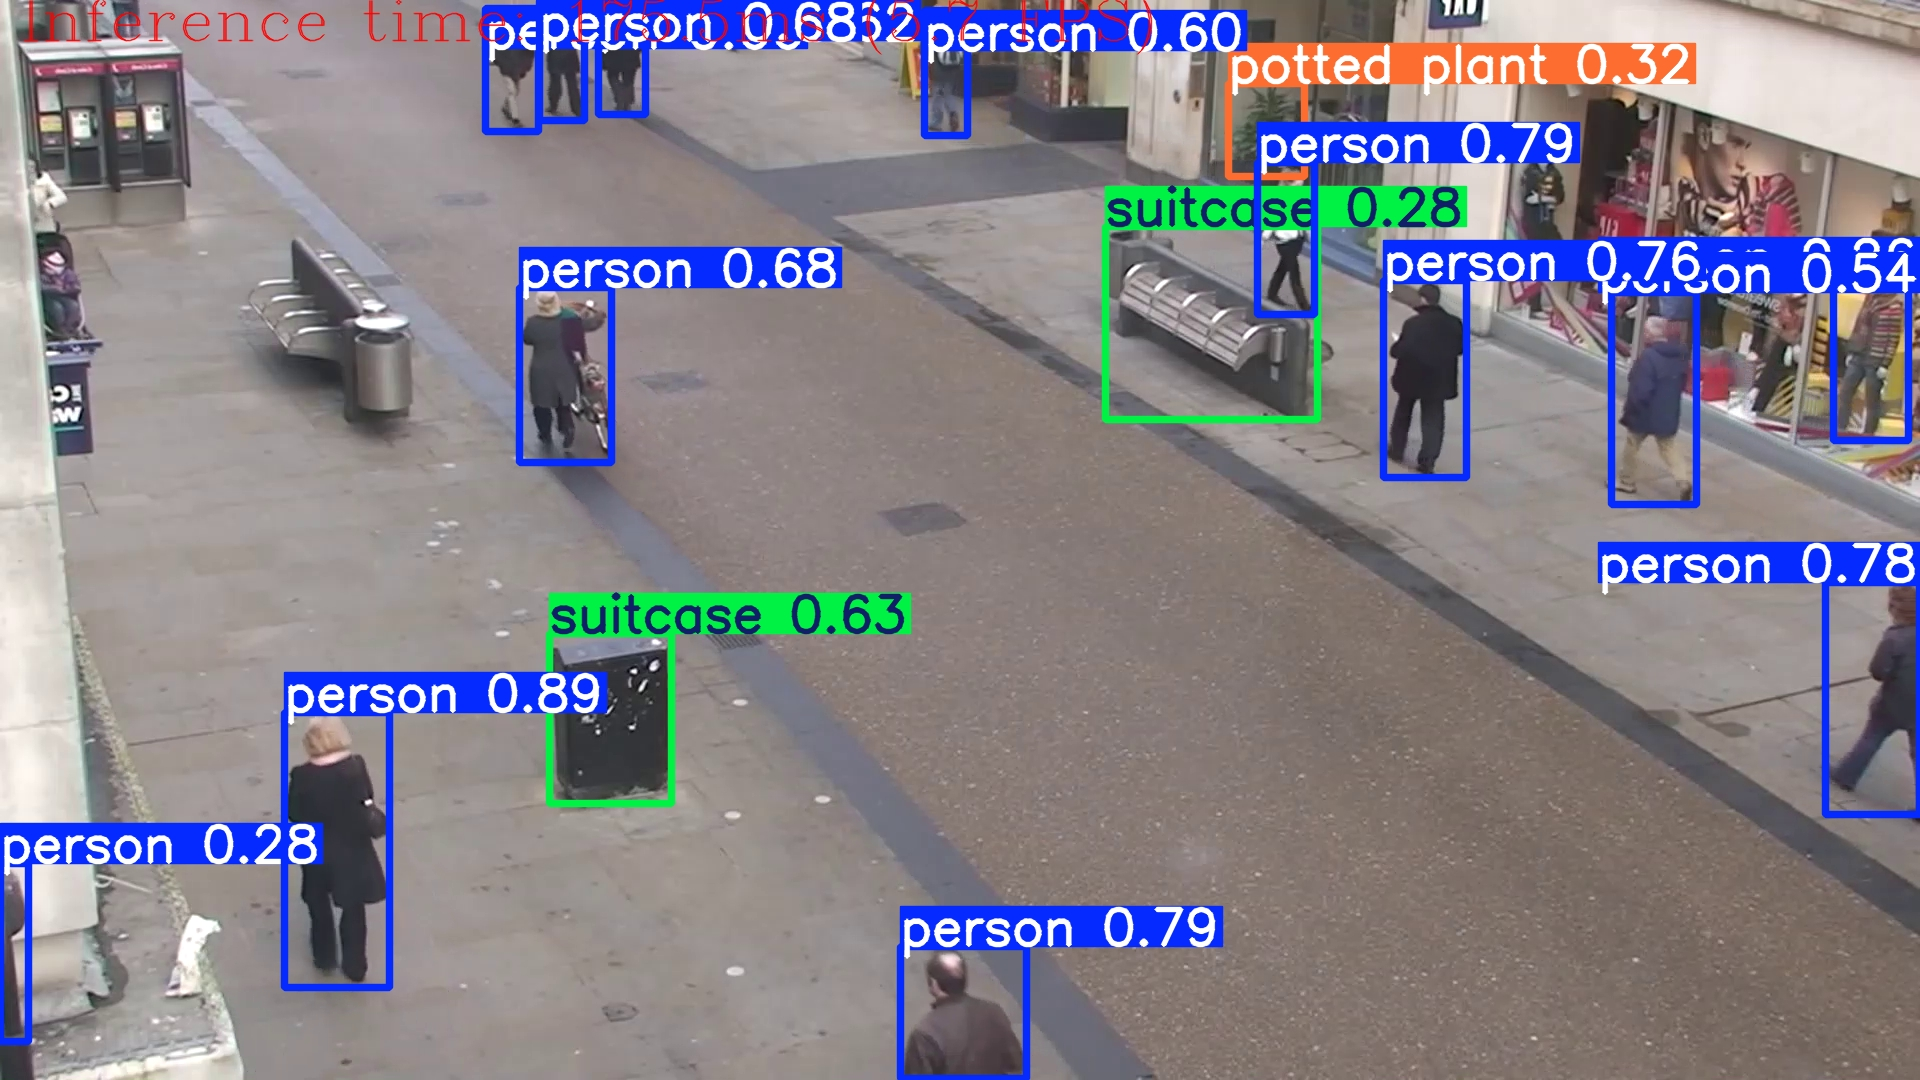

Source ended


In [22]:
run_object_detection(
    source=VIDEO_SOURCE,
    flip=True,
    use_popup=False,
    model=det_model,
    device=device.value,
    # video_width=1280,
)